mise a jour le code pour que ne limiter pas nomber de frame faire simulation jusqua terminer tout les passengers et limiter le nomber de passegerer to 20 

Loading OSM graph...
Graph loaded: 1439 nodes, 2075 edges
Saving GIF amélioré...


C:\Users\bmlla\AppData\Local\Temp\ipykernel_1596\3897446819.py:467: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


Saved: simulation_optimized.gif


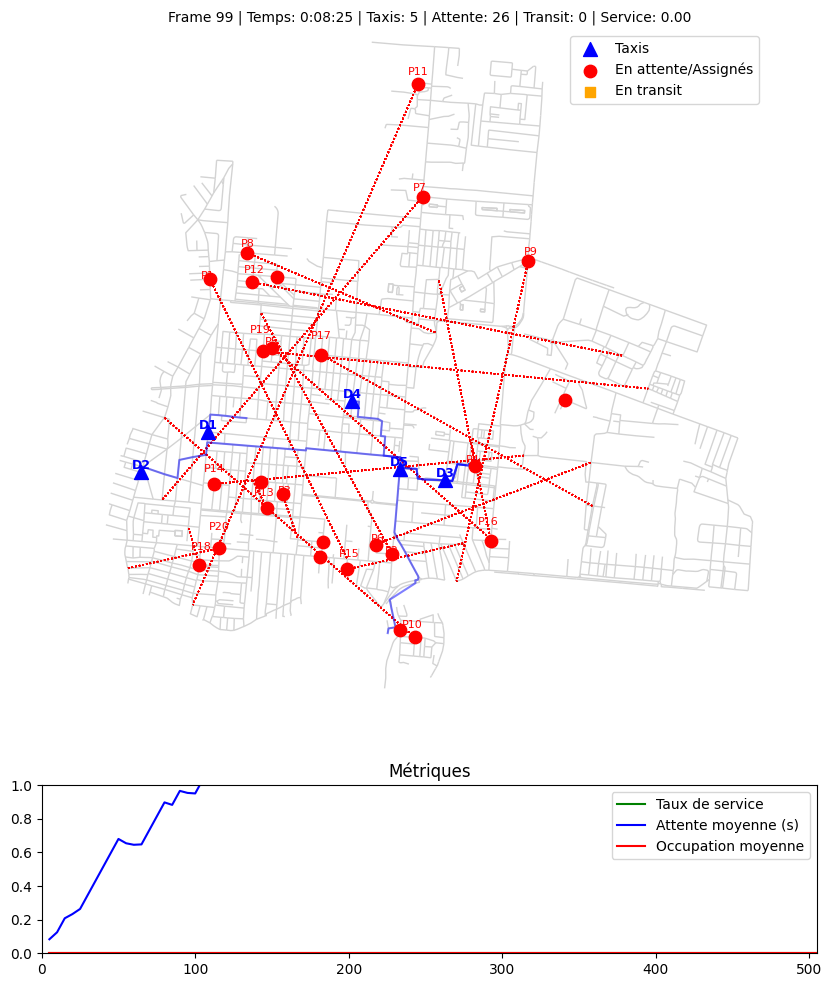

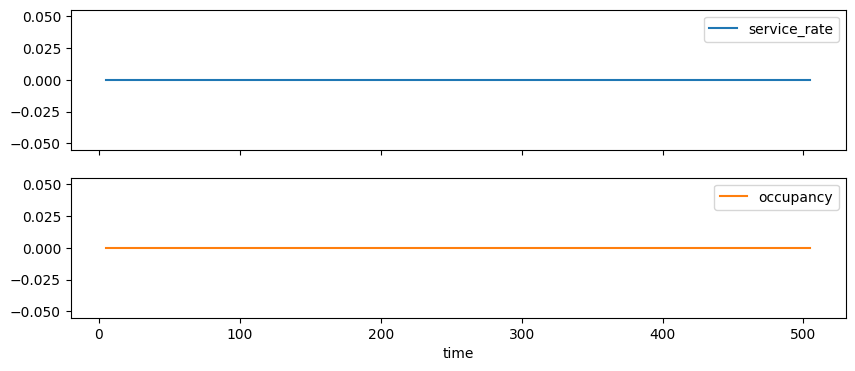

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import re
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import defaultdict

# -----------------------------
# CONFIG
# -----------------------------
PLACE = "Bordj El Bahri, Algeria"
NUM_DRIVERS = 5
CAPACITY = 3  # Max passengers per taxi
NUM_INITIAL_PASSENGERS = 3
SPAWN_RATE = 0.2
DETOUR_MAX = 1.2  # +20% distance
MAX_WAIT = 300.0  # Seconds max wait
MAX_RIDE_TIME = 600.0  # Max ride time per passenger (s)
PICKUP_WINDOW = 120.0  # Max time to pickup from current pos (s)
SPEED_FACTOR = 4.0
DT = 5
FRAMES = 100
GIF_OUTPUT = "simulation_optimized.gif"
CURRENT_TIME = 0.0
LABEL_OFFSET = 0.00015  # For non-overlapping labels

# -----------------------------
# Classes
# -----------------------------
class Passenger:
    def __init__(self, pid, origin, dest, request_time):
        self.id = pid
        self.origin = origin
        self.dest = dest
        self.status = "waiting"  # waiting, assigned, in_transit, dropped
        self.request_time = request_time
        self.pickup_time = None
        self.drop_time = None
        self.drop_frame = None

class Driver:
    def __init__(self, did, start_node, G):
        self.id = did
        self.node = start_node
        self.pos = (G.nodes[start_node]['x'], G.nodes[start_node]['y'])
        self.route = [start_node]
        self.route_types = ['start']  # start, end, pickup, dropoff
        self.route_passengers = [None]
        self.onboard = []
        self.assigned = []
        self.edge = None
        self.progress = 0.0

# -----------------------------
# Utility Functions (améliorées)
# -----------------------------
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi, dlambda = math.radians(lat2 - lat1), math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

def get_edge_attr(G, u, v):
    ed = G.get_edge_data(u, v)
    if ed is None or not isinstance(ed, dict):
        return {}
    return ed

def parse_maxspeed(val):
    if val is None:
        return 50.0
    if isinstance(val, (list, tuple)):
        val = val[0]
    s = str(val)
    m = re.search(r'(\d+(\.\d+)?)', s)
    return float(m.group(1)) if m else 50.0

def get_edge_speed_m_s(G, u, v):
    attr = get_edge_attr(G, u, v)
    ms = parse_maxspeed(attr.get('maxspeed'))
    return ms * 1000.0 / 3600.0

def get_edge_length_m(G, u, v):
    attr = get_edge_attr(G, u, v)
    if 'length' in attr and attr['length']:
        return float(attr['length'])
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    return haversine_m(y1, x1, y2, x2)  # Note: OSMnx uses (x=lon, y=lat)

def get_edge_time_s(G, u, v):
    length = get_edge_length_m(G, u, v)
    speed = get_edge_speed_m_s(G, u, v)
    return length / speed if speed > 0 else float('inf')

def route_distance(G, route):
    if len(route) < 2:
        return 0.0
    return sum(get_edge_length_m(G, route[i], route[i+1]) for i in range(len(route)-1))

def route_time(G, route):
    if len(route) < 2:
        return 0.0
    return sum(get_edge_time_s(G, route[i], route[i+1]) for i in range(len(route)-1))

def concat_route_safe(G, waypoints):
    if len(waypoints) < 2:
        return waypoints
    full = [waypoints[0]]
    for a, b in zip(waypoints[:-1], waypoints[1:]):
        try:
            sub = nx.shortest_path(G, a, b, weight='length')
            full.extend(sub[1:])
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return []  # Invalid
    return full

# -----------------------------
# Load Graph
# -----------------------------
print("Loading OSM graph...")
G = ox.graph_from_place(PLACE, network_type="drive")
G = G.to_undirected()
nodes = list(G.nodes)
print(f"Graph loaded: {len(nodes)} nodes, {len(G.edges)} edges")

# -----------------------------
# Initialize
# -----------------------------
drivers = [Driver(f"D{i+1}", random.choice(nodes), G) for i in range(NUM_DRIVERS)]
passengers = [Passenger(f"P{i+1}", random.choice(nodes), random.choice(nodes), 0.0) for i in range(NUM_INITIAL_PASSENGERS)]
for p in passengers:
    while p.origin == p.dest:
        p.dest = random.choice(nodes)

# Initial routes for drivers
for drv in drivers:
    target = random.choice(nodes)
    route = concat_route_safe(G, [drv.node, target])
    if route:
        drv.route = route
        drv.route_types = ['start'] + ['end'] * (len(route) - 1)
        drv.route_passengers = [None] * len(route)

# Metrics tracking
metrics_df = pd.DataFrame(columns=['time', 'service_rate', 'avg_wait', 'occupancy'])
all_passengers = len(passengers)  # Track total ever

# -----------------------------
# Improved Assignment
# -----------------------------
def insert_passenger(G, drv, p, current_time):
    origin, dest = p.origin, p.dest
    direct_route = concat_route_safe(G, [origin, dest])
    if not direct_route:
        return float('inf'), None, -1, -1
    direct_dist = route_distance(G, direct_route)
    current_route = drv.route
    n_stops = min(len(current_route), 15)  # Limit for optimization
    best_added = float('inf')
    best_new_route = None
    best_i, best_j = -1, -1
    best_pickup_time = float('inf')
    best_ride_time = float('inf')

    for i in range(n_stops):
        for j in range(i + 2, min(n_stops + 2, n_stops + 3)):  # j > i+1
            # Build new route with shortest paths
            seg1 = concat_route_safe(G, [current_route[i], origin])
            seg2 = concat_route_safe(G, [origin, dest])
            seg3 = concat_route_safe(G, [dest, current_route[j-1] if j < len(current_route) else current_route[-1]])
            if not all([seg1, seg2, seg3]):
                continue
            new_route = current_route[:i+1] + seg1[1:] + seg2 + seg3[1:] + current_route[j:]
            if not new_route:  # Invalid path
                continue

            # Check capacity along route
            onboard_count = len(drv.onboard)
            feasible = True
            for k in range(1, len(new_route)):
                if new_route[k] == origin:
                    onboard_count += 1
                elif new_route[k] == dest:
                    onboard_count -= 1
                if onboard_count > CAPACITY:
                    feasible = False
                    break

            if not feasible:
                continue

            # Detour check
            new_dist = route_distance(G, new_route)
            old_dist = route_distance(G, current_route)
            added_dist = new_dist - old_dist
            if added_dist > (DETOUR_MAX - 1) * direct_dist:
                continue

            # Time to pickup (from current pos to origin via i)
            path_to_pickup = concat_route_safe(G, [drv.node, current_route[i], origin])
            time_to_pickup = route_time(G, path_to_pickup)
            estimated_wait = current_time - p.request_time + time_to_pickup
            if estimated_wait > MAX_WAIT or time_to_pickup > PICKUP_WINDOW:
                continue

            # Max ride time (pickup to dropoff)
            ride_route = concat_route_safe(G, [origin, dest])
            ride_time = route_time(G, ride_route)
            if ride_time > MAX_RIDE_TIME:
                continue

            # Ensure dropoff after pickup (simple check: dest after origin in route)
            pickup_idx = new_route.index(origin)
            drop_idx = new_route.index(dest)
            if drop_idx <= pickup_idx:
                continue

            if added_dist < best_added:
                best_added = added_dist
                best_new_route = new_route
                best_i, best_j = i, j
                best_pickup_time = time_to_pickup
                best_ride_time = ride_time

    return best_added, best_new_route, best_i, best_j

def assign_passengers(G, drivers, passengers, current_time):
    waiting = [p for p in passengers if p.status == "waiting"]
    for p in waiting[:]:  # Copy to avoid mod during iter
        best_drv = None
        best_added = float('inf')
        best_new_route = None
        best_i, best_j = -1, -1
        for drv in drivers:
            if len(drv.onboard) + len(drv.assigned) >= CAPACITY:
                continue
            added, new_route, i, j = insert_passenger(G, drv, p, current_time)
            if added < best_added and new_route:
                best_added = added
                best_drv = drv
                best_new_route = new_route
                best_i, best_j = i, j
        if best_drv:
            # Update route types and passengers
            types = best_drv.route_types[:best_i+1] + ['pickup'] + best_drv.route_types[best_i+1:best_j] + ['dropoff'] + best_drv.route_types[best_j:]
            pass_list = best_drv.route_passengers[:best_i+1] + [p.id] + best_drv.route_passengers[best_i+1:best_j] + [p.id] + best_drv.route_passengers[best_j:]
            best_drv.route = best_new_route
            best_drv.route_types = types[:len(best_new_route)]  # Trim if needed
            best_drv.route_passengers = pass_list[:len(best_new_route)]
            p.status = "assigned"
            best_drv.assigned.append(p.id)
            print(f"Assigned {p.id} to {best_drv.id} (added dist: {best_added:.1f}m)")

# -----------------------------
# Movement (fixed frame issue)
# -----------------------------
def move_driver_step(G, driver, dt, frame):
    if len(driver.route) <= 1:
        # Repan idle
        target = random.choice(nodes)
        new_route = concat_route_safe(G, [driver.node, target])
        if new_route:
            driver.route = new_route
            driver.route_types = ['start'] + ['end'] * (len(new_route) - 1)
            driver.route_passengers = [None] * len(new_route)
        return

    if driver.edge is None:
        next_node = driver.route[1]
        if G.has_edge(driver.node, next_node):
            driver.edge = (driver.node, next_node)
            driver.progress = 0.0
        else:
            # Skip invalid
            driver.route = driver.route[1:]
            driver.route_types = driver.route_types[1:]
            driver.route_passengers = driver.route_passengers[1:]
            return

    if driver.edge:
        u, v = driver.edge
        if not G.has_edge(u, v):
            driver.edge = None
            driver.route = driver.route[1:]
            driver.route_types = driver.route_types[1:]
            driver.route_passengers = driver.route_passengers[1:]
            return

        length = get_edge_length_m(G, u, v)
        speed = get_edge_speed_m_s(G, u, v) * SPEED_FACTOR
        travel = speed * dt
        driver.progress += travel

        if driver.progress >= length:
            driver.node = v
            driver.pos = (G.nodes[v]['x'], G.nodes[v]['y'])
            driver.progress = 0.0
            driver.edge = None

            if len(driver.route) > 1:
                next_type = driver.route_types[1]
                next_pax = driver.route_passengers[1]
                if next_type == 'pickup' and next_pax in driver.assigned:
                    driver.onboard.append(next_pax)
                    driver.assigned.remove(next_pax)
                    for pp in passengers:
                        if pp.id == next_pax:
                            pp.status = "in_transit"
                            pp.pickup_time = CURRENT_TIME
                            break
                elif next_type == 'dropoff' and next_pax in driver.onboard:
                    driver.onboard.remove(next_pax)
                    for pp in passengers:
                        if pp.id == next_pax:
                            pp.status = "dropped"
                            pp.drop_time = CURRENT_TIME
                            pp.drop_frame = frame
                            break
                driver.route = driver.route[1:]
                driver.route_types = driver.route_types[1:]
                driver.route_passengers = driver.route_passengers[1:]
        else:
            # Interpolate pos
            x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
            x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
            ratio = driver.progress / length
            driver.pos = (x1 + (x2 - x1) * ratio, y1 + (y2 - y1) * ratio)

# -----------------------------
# Visualization (améliorée)
# -----------------------------
fig, (ax_map, ax_metrics) = plt.subplots(2, 1, figsize=(10, 12), height_ratios=[4, 1])
ax_map.set_axis_off()
ox.plot_graph(G, ax=ax_map, node_size=0, edge_color="lightgray", show=False, close=False)
ax_map.grid(True, linestyle='--', alpha=0.3)

driver_scatter = ax_map.scatter([], [], c='blue', s=100, marker='^', zorder=4, label='Taxis')
passenger_scatter = ax_map.scatter([], [], c='red', s=80, marker='o', zorder=3, label='En attente/Assignés')
in_transit_scatter = ax_map.scatter([], [], c='orange', s=60, marker='s', zorder=5, label='En transit')  # Smaller for multiples
temp_artists = []
labels = []  # Combined

ax_map.legend(loc='upper right')

# Metrics line
service_line, = ax_metrics.plot([], [], 'g-', label='Taux de service')
wait_line, = ax_metrics.plot([], [], 'b-', label='Attente moyenne (s)')
occ_line, = ax_metrics.plot([], [], 'r-', label='Occupation moyenne')
ax_metrics.set_xlim(0, FRAMES)
ax_metrics.set_ylim(0, 1)
ax_metrics.legend()
ax_metrics.set_title('Métriques')

def get_offset_pos(pos, idx, max_offset=3):
    """Offset pour éviter chevauchements"""
    dx = LABEL_OFFSET * (idx % max_offset - max_offset // 2)
    dy = LABEL_OFFSET * (idx // max_offset)
    return (pos[0] + dx, pos[1] + dy)

def update(frame):
    global CURRENT_TIME, temp_artists, labels, all_passengers
    CURRENT_TIME += DT
    # Clean old artists
    for art in temp_artists:
        art.remove()
    for lbl in labels:
        lbl.remove()
    temp_artists = []
    labels = []

    # Spawn new
    if random.random() < SPAWN_RATE:
        o = random.choice(nodes)
        d = random.choice(nodes)
        while o == d:
            d = random.choice(nodes)
        new_p = Passenger(f"P{len(passengers)+1}", o, d, CURRENT_TIME)
        passengers.append(new_p)
        all_passengers += 1
        # Fade-in
        px, py = G.nodes[o]['x'], G.nodes[o]['y']
        sc = ax_map.scatter(px, py, c='yellow', s=80, alpha=0.5, zorder=3)
        temp_artists.append(sc)

    assign_passengers(G, drivers, passengers, CURRENT_TIME)

    for drv in drivers:
        move_driver_step(G, drv, DT, frame)

    # Update positions
    dx = [d.pos[0] for d in drivers]
    dy = [d.pos[1] for d in drivers]
    driver_scatter.set_offsets(list(zip(dx, dy)))

    # Waiting/assigned at origin
    wait_xy = [(G.nodes[p.origin]['x'], G.nodes[p.origin]['y']) for p in passengers if p.status in ["waiting", "assigned"]]
    passenger_scatter.set_offsets(wait_xy if wait_xy else np.empty((0, 2)))

    # In transit: one point per driver with onboard, offset slightly
    in_transit_xy = []
    for drv in drivers:
        if drv.onboard:
            base_pos = drv.pos
            for idx, _ in enumerate(drv.onboard):
                off_pos = get_offset_pos(base_pos, idx)
                in_transit_xy.append(off_pos)
    in_transit_scatter.set_offsets(in_transit_xy if in_transit_xy else np.empty((0, 2)))

    # Dropped: fade at dest
    for p in [p for p in passengers if p.status == "dropped" and hasattr(p, 'drop_frame')]:
        if frame - p.drop_frame <= 10:
            alpha = max(0, 1 - (frame - p.drop_frame) / 10.0)
            px, py = G.nodes[p.dest]['x'], G.nodes[p.dest]['y']
            sc = ax_map.scatter(px, py, c='green', s=80, marker='x', alpha=alpha, zorder=3)
            temp_artists.append(sc)
            lbl = ax_map.text(px, py + LABEL_OFFSET, p.id, fontsize=8, color='green', alpha=alpha, ha='center', zorder=5)
            labels.append(lbl)

    # Routes: color by type
    for drv in drivers:
        if len(drv.route) > 1:
            coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in drv.route]
            xs, ys = zip(*coords)
            color = 'green' if any(t in ['pickup', 'dropoff'] for t in drv.route_types) else 'blue'
            ln = ax_map.plot(xs, ys, color=color, linewidth=1.5, alpha=0.5, zorder=2, linestyle='--' if 'pickup' in drv.route_types else '-')[0]
            temp_artists.append(ln)
        # Driver label
        dlbl = ax_map.text(drv.pos[0], drv.pos[1] + LABEL_OFFSET, drv.id, fontsize=9, color='blue', ha='center', zorder=5, weight='bold')
        labels.append(dlbl)
        # Onboard labels offset
        for idx, pid in enumerate(drv.onboard):
            off_pos = get_offset_pos(drv.pos, idx + 1)
            plbl = ax_map.text(off_pos[0], off_pos[1], pid, fontsize=7, color='orange', zorder=5)
            labels.append(plbl)

    # Waiting labels
    for idx, p in enumerate([p for p in passengers if p.status in ["waiting", "assigned"]]):
        if idx < 20:  # Limit to avoid clutter
            px, py = G.nodes[p.origin]['x'], G.nodes[p.origin]['y']
            off_pos = get_offset_pos((px, py), idx)
            plbl = ax_map.text(off_pos[0], off_pos[1], p.id, fontsize=8, color='red', ha='center', zorder=5)
            labels.append(plbl)
            # Dest line
            dx, dy = G.nodes[p.dest]['x'], G.nodes[p.dest]['y']
            ax_map.plot([px, dx], [py, dy], 'r:', alpha=0.3, linewidth=1, zorder=1)

    # Clean old passengers
    passengers[:] = [p for p in passengers if not (p.status == "dropped" and hasattr(p, 'drop_frame') and frame - p.drop_frame > 10)]

    # Metrics
    served = len([p for p in passengers if p.status == "dropped"])
    total_req = all_passengers
    service_rate = served / total_req if total_req > 0 else 0
    waiting_p = [p for p in passengers if p.status == "waiting"]
    avg_wait = np.mean([CURRENT_TIME - p.request_time for p in waiting_p]) if waiting_p else 0
    avg_occ = np.mean([len(d.onboard) / CAPACITY for d in drivers]) if drivers else 0

    new_row = pd.DataFrame({'time': [CURRENT_TIME], 'service_rate': [service_rate], 'avg_wait': [avg_wait], 'occupancy': [avg_occ]})
    global metrics_df
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    service_line.set_data(metrics_df['time'], metrics_df['service_rate'])
    wait_line.set_data(metrics_df['time'], metrics_df['avg_wait'] / 60)  # Min for scale
    occ_line.set_data(metrics_df['time'], metrics_df['occupancy'])
    ax_metrics.set_xlim(0, CURRENT_TIME)

    title = f"Frame {frame} | Temps: {timedelta(seconds=int(CURRENT_TIME))} | Taxis: {NUM_DRIVERS} | Attente: {len(waiting_p)} | Transit: {len(in_transit_xy)} | Service: {service_rate:.2f}"
    ax_map.set_title(title, fontsize=10)

    return [driver_scatter, passenger_scatter, in_transit_scatter, service_line, wait_line, occ_line] + temp_artists + labels

# -----------------------------
# Run Animation
# -----------------------------
anim = animation.FuncAnimation(fig, update, frames=FRAMES, interval=200, blit=False, repeat=False)
print("Saving GIF amélioré...")
anim.save(GIF_OUTPUT, writer=animation.PillowWriter(fps=10))
print(f"Saved: {GIF_OUTPUT}")

# Plot final metrics
metrics_df.plot(x='time', y=['service_rate', 'occupancy'], subplots=True, figsize=(10, 4))
plt.savefig("metrics.png")
plt.show()

plt.show()

script sans visualisation 

In [2]:
import osmnx as ox
import networkx as nx
import random
import math
import re
import numpy as np
import pandas as pd
from datetime import timedelta

# -----------------------------
# CONFIG
# -----------------------------
PLACE = "Bordj El Bahri, Algeria"
NUM_DRIVERS = 5
CAPACITY = 3  # Max passengers per taxi
NUM_INITIAL_PASSENGERS = 3
SPAWN_RATE = 0.2
DETOUR_MAX = 1.2  # +20% distance
MAX_WAIT = 300.0  # Seconds max wait
MAX_RIDE_TIME = 600.0  # Max ride time per passenger (s)
PICKUP_WINDOW = 120.0  # Max time to pickup from current pos (s)
SPEED_FACTOR = 4.0
DT = 5
FRAMES = 100  # Nombre d'étapes de simulation
CURRENT_TIME = 0.0

# -----------------------------
# Classes
# -----------------------------
class Passenger:
    def __init__(self, pid, origin, dest, request_time):
        self.id = pid
        self.origin = origin
        self.dest = dest
        self.status = "waiting"  # waiting, assigned, in_transit, dropped
        self.request_time = request_time
        self.pickup_time = None
        self.drop_time = None
        self.drop_frame = None

class Driver:
    def __init__(self, did, start_node, G):
        self.id = did
        self.node = start_node
        self.pos = (G.nodes[start_node]['x'], G.nodes[start_node]['y'])
        self.route = [start_node]
        self.route_types = ['start']  # start, end, pickup, dropoff
        self.route_passengers = [None]
        self.onboard = []
        self.assigned = []
        self.edge = None
        self.progress = 0.0

# -----------------------------
# Utility Functions (améliorées)
# -----------------------------
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi, dlambda = math.radians(lat2 - lat1), math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

def get_edge_attr(G, u, v):
    ed = G.get_edge_data(u, v)
    if ed is None or not isinstance(ed, dict):
        return {}
    return ed

def parse_maxspeed(val):
    if val is None:
        return 50.0
    if isinstance(val, (list, tuple)):
        val = val[0]
    s = str(val)
    m = re.search(r'(\d+(\.\d+)?)', s)
    return float(m.group(1)) if m else 50.0

def get_edge_speed_m_s(G, u, v):
    attr = get_edge_attr(G, u, v)
    ms = parse_maxspeed(attr.get('maxspeed'))
    return ms * 1000.0 / 3600.0

def get_edge_length_m(G, u, v):
    attr = get_edge_attr(G, u, v)
    if 'length' in attr and attr['length']:
        return float(attr['length'])
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    return haversine_m(y1, x1, y2, x2)  # Note: OSMnx uses (x=lon, y=lat)

def get_edge_time_s(G, u, v):
    length = get_edge_length_m(G, u, v)
    speed = get_edge_speed_m_s(G, u, v)
    return length / speed if speed > 0 else float('inf')

def route_distance(G, route):
    if len(route) < 2:
        return 0.0
    return sum(get_edge_length_m(G, route[i], route[i+1]) for i in range(len(route)-1))

def route_time(G, route):
    if len(route) < 2:
        return 0.0
    return sum(get_edge_time_s(G, route[i], route[i+1]) for i in range(len(route)-1))

def concat_route_safe(G, waypoints):
    if len(waypoints) < 2:
        return waypoints
    full = [waypoints[0]]
    for a, b in zip(waypoints[:-1], waypoints[1:]):
        try:
            sub = nx.shortest_path(G, a, b, weight='length')
            full.extend(sub[1:])
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return []  # Invalid
    return full

# -----------------------------
# Load Graph
# -----------------------------
print("Loading OSM graph...")
G = ox.graph_from_place(PLACE, network_type="drive")
G = G.to_undirected()
nodes = list(G.nodes)
print(f"Graph loaded: {len(nodes)} nodes, {len(G.edges)} edges")

# -----------------------------
# Initialize
# -----------------------------
drivers = [Driver(f"D{i+1}", random.choice(nodes), G) for i in range(NUM_DRIVERS)]
passengers = [Passenger(f"P{i+1}", random.choice(nodes), random.choice(nodes), 0.0) for i in range(NUM_INITIAL_PASSENGERS)]
for p in passengers:
    while p.origin == p.dest:
        p.dest = random.choice(nodes)

# Initial routes for drivers
for drv in drivers:
    target = random.choice(nodes)
    route = concat_route_safe(G, [drv.node, target])
    if route:
        drv.route = route
        drv.route_types = ['start'] + ['end'] * (len(route) - 1)
        drv.route_passengers = [None] * len(route)

# Metrics tracking
metrics_df = pd.DataFrame(columns=['step', 'time', 'service_rate', 'avg_wait', 'occupancy', 'waiting_count', 'in_transit_count'])
all_passengers = len(passengers)  # Track total ever
frame = 0

# -----------------------------
# Improved Assignment
# -----------------------------
def insert_passenger(G, drv, p, current_time):
    origin, dest = p.origin, p.dest
    direct_route = concat_route_safe(G, [origin, dest])
    if not direct_route:
        return float('inf'), None, -1, -1
    direct_dist = route_distance(G, direct_route)
    current_route = drv.route
    n_stops = min(len(current_route), 15)  # Limit for optimization
    best_added = float('inf')
    best_new_route = None
    best_i, best_j = -1, -1
    best_pickup_time = float('inf')
    best_ride_time = float('inf')

    for i in range(n_stops):
        for j in range(i + 2, min(n_stops + 2, n_stops + 3)):  # j > i+1
            # Build new route with shortest paths
            seg1 = concat_route_safe(G, [current_route[i], origin])
            seg2 = concat_route_safe(G, [origin, dest])
            seg3 = concat_route_safe(G, [dest, current_route[j-1] if j < len(current_route) else current_route[-1]])
            if not all([seg1, seg2, seg3]):
                continue
            new_route = current_route[:i+1] + seg1[1:] + seg2 + seg3[1:] + current_route[j:]
            if not new_route:  # Invalid path
                continue

            # Check capacity along route
            onboard_count = len(drv.onboard)
            feasible = True
            for k in range(1, len(new_route)):
                if new_route[k] == origin:
                    onboard_count += 1
                elif new_route[k] == dest:
                    onboard_count -= 1
                if onboard_count > CAPACITY:
                    feasible = False
                    break

            if not feasible:
                continue

            # Detour check
            new_dist = route_distance(G, new_route)
            old_dist = route_distance(G, current_route)
            added_dist = new_dist - old_dist
            if added_dist > (DETOUR_MAX - 1) * direct_dist:
                continue

            # Time to pickup (from current pos to origin via i)
            path_to_pickup = concat_route_safe(G, [drv.node, current_route[i], origin])
            time_to_pickup = route_time(G, path_to_pickup)
            estimated_wait = current_time - p.request_time + time_to_pickup
            if estimated_wait > MAX_WAIT or time_to_pickup > PICKUP_WINDOW:
                continue

            # Max ride time (pickup to dropoff)
            ride_route = concat_route_safe(G, [origin, dest])
            ride_time = route_time(G, ride_route)
            if ride_time > MAX_RIDE_TIME:
                continue

            # Ensure dropoff after pickup (simple check: dest after origin in route)
            pickup_idx = new_route.index(origin)
            drop_idx = new_route.index(dest)
            if drop_idx <= pickup_idx:
                continue

            if added_dist < best_added:
                best_added = added_dist
                best_new_route = new_route
                best_i, best_j = i, j
                best_pickup_time = time_to_pickup
                best_ride_time = ride_time

    return best_added, best_new_route, best_i, best_j

def assign_passengers(G, drivers, passengers, current_time):
    waiting = [p for p in passengers if p.status == "waiting"]
    for p in waiting[:]:  # Copy to avoid mod during iter
        best_drv = None
        best_added = float('inf')
        best_new_route = None
        best_i, best_j = -1, -1
        for drv in drivers:
            if len(drv.onboard) + len(drv.assigned) >= CAPACITY:
                continue
            added, new_route, i, j = insert_passenger(G, drv, p, current_time)
            if added < best_added and new_route:
                best_added = added
                best_drv = drv
                best_new_route = new_route
                best_i, best_j = i, j
        if best_drv:
            # Update route types and passengers
            types = best_drv.route_types[:best_i+1] + ['pickup'] + best_drv.route_types[best_i+1:best_j] + ['dropoff'] + best_drv.route_types[best_j:]
            pass_list = best_drv.route_passengers[:best_i+1] + [p.id] + best_drv.route_passengers[best_i+1:best_j] + [p.id] + best_drv.route_passengers[best_j:]
            best_drv.route = best_new_route
            best_drv.route_types = types[:len(best_new_route)]  # Trim if needed
            best_drv.route_passengers = pass_list[:len(best_new_route)]
            p.status = "assigned"
            best_drv.assigned.append(p.id)
            print(f"Assigned {p.id} to {best_drv.id} (added dist: {best_added:.1f}m)")

# -----------------------------
# Movement (fixed frame issue)
# -----------------------------
def move_driver_step(G, driver, dt, frame):
    if len(driver.route) <= 1:
        # Repan idle
        target = random.choice(nodes)
        new_route = concat_route_safe(G, [driver.node, target])
        if new_route:
            driver.route = new_route
            driver.route_types = ['start'] + ['end'] * (len(new_route) - 1)
            driver.route_passengers = [None] * len(new_route)
        return

    if driver.edge is None:
        next_node = driver.route[1]
        if G.has_edge(driver.node, next_node):
            driver.edge = (driver.node, next_node)
            driver.progress = 0.0
        else:
            # Skip invalid
            driver.route = driver.route[1:]
            driver.route_types = driver.route_types[1:]
            driver.route_passengers = driver.route_passengers[1:]
            return

    if driver.edge:
        u, v = driver.edge
        if not G.has_edge(u, v):
            driver.edge = None
            driver.route = driver.route[1:]
            driver.route_types = driver.route_types[1:]
            driver.route_passengers = driver.route_passengers[1:]
            return

        length = get_edge_length_m(G, u, v)
        speed = get_edge_speed_m_s(G, u, v) * SPEED_FACTOR
        travel = speed * dt
        driver.progress += travel

        if driver.progress >= length:
            driver.node = v
            driver.pos = (G.nodes[v]['x'], G.nodes[v]['y'])
            driver.progress = 0.0
            driver.edge = None

            if len(driver.route) > 1:
                next_type = driver.route_types[1]
                next_pax = driver.route_passengers[1]
                if next_type == 'pickup' and next_pax in driver.assigned:
                    driver.onboard.append(next_pax)
                    driver.assigned.remove(next_pax)
                    for pp in passengers:
                        if pp.id == next_pax:
                            pp.status = "in_transit"
                            pp.pickup_time = CURRENT_TIME
                            break
                elif next_type == 'dropoff' and next_pax in driver.onboard:
                    driver.onboard.remove(next_pax)
                    for pp in passengers:
                        if pp.id == next_pax:
                            pp.status = "dropped"
                            pp.drop_time = CURRENT_TIME
                            pp.drop_frame = frame
                            break
                driver.route = driver.route[1:]
                driver.route_types = driver.route_types[1:]
                driver.route_passengers = driver.route_passengers[1:]
        else:
            # Interpolate pos
            x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
            x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
            ratio = driver.progress / length
            driver.pos = (x1 + (x2 - x1) * ratio, y1 + (y2 - y1) * ratio)

# -----------------------------
# Simulation Loop (sans visualisation)
# -----------------------------
print("Démarrage de la simulation...")
for frame in range(FRAMES):
    CURRENT_TIME += DT
    frame += 1  # Global frame

    # Spawn new
    if random.random() < SPAWN_RATE:
        o = random.choice(nodes)
        d = random.choice(nodes)
        while o == d:
            d = random.choice(nodes)
        new_p = Passenger(f"P{len(passengers)+1}", o, d, CURRENT_TIME)
        passengers.append(new_p)
        all_passengers += 1
        print(f"Nouveau passager {new_p.id} spawné à t={CURRENT_TIME:.0f}s")

    # Assign passengers
    assign_passengers(G, drivers, passengers, CURRENT_TIME)

    # Move drivers
    for drv in drivers:
        move_driver_step(G, drv, DT, frame)

    # Clean old passengers (dropped >10 steps)
    passengers[:] = [p for p in passengers if not (p.status == "dropped" and hasattr(p, 'drop_frame') and frame - p.drop_frame > 10)]

    # Metrics
    served = len([p for p in passengers if p.status == "dropped"])
    total_req = all_passengers
    service_rate = served / total_req if total_req > 0 else 0
    waiting_p = [p for p in passengers if p.status == "waiting"]
    avg_wait = np.mean([CURRENT_TIME - p.request_time for p in waiting_p]) if waiting_p else 0
    avg_occ = np.mean([len(d.onboard) / CAPACITY for d in drivers]) if drivers else 0
    in_transit_count = sum(len(d.onboard) for d in drivers)
    waiting_count = len(waiting_p)

    new_row = pd.DataFrame({
        'step': [frame], 'time': [CURRENT_TIME], 'service_rate': [service_rate], 
        'avg_wait': [avg_wait], 'occupancy': [avg_occ], 
        'waiting_count': [waiting_count], 'in_transit_count': [in_transit_count]
    })
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    # Print progress every 10 steps
    if frame % 10 == 0:
        print(f"Step {frame}/{FRAMES} | Temps: {timedelta(seconds=int(CURRENT_TIME))} | "
              f"Requêtes total: {total_req} | Servi: {served} ({service_rate:.2f}) | "
              f"Attente: {waiting_count} | Transit: {in_transit_count} | Occ moy: {avg_occ:.2f}")

print("Simulation terminée.")

# -----------------------------
# Affichage des Résultats et Métriques
# -----------------------------
print("\n=== RÉSUMÉ FINAL ===")
final_served = len([p for p in passengers if p.status == "dropped"])
final_total = all_passengers
final_service_rate = final_served / final_total if final_total > 0 else 0
final_waiting = len([p for p in passengers if p.status == "waiting"])
final_in_transit = sum(len(d.onboard) for d in drivers)
final_avg_occ = np.mean([len(d.onboard) / CAPACITY for d in drivers]) if drivers else 0
final_avg_wait = np.mean([CURRENT_TIME - p.request_time for p in [p for p in passengers if p.status == "waiting"]]) if final_waiting > 0 else 0

print(f"Temps total simulé: {timedelta(seconds=int(CURRENT_TIME))}")
print(f"Requêtes totales: {final_total}")
print(f"Passagers servis: {final_served} (Taux: {final_service_rate:.2f})")
print(f"Passagers en attente: {final_waiting}")
print(f"Passagers en transit: {final_in_transit}")
print(f"Occupation moyenne: {final_avg_occ:.2f}")
print(f"Attente moyenne (en attente): {final_avg_wait:.1f}s")

print("\n=== MÉTRIQUES DÉTAILLÉES (Tableau) ===")
print(metrics_df.round(3).to_string(index=False))

# Sauvegarde CSV pour analyse
metrics_df.to_csv("metrics_simulation.csv", index=False)
print("\nMétriques sauvegardées dans 'metrics_simulation.csv'")

# Stats avancées
print("\n=== STATS PAR TAXI ===")
for drv in drivers:
    onboard_count = len(drv.onboard)
    assigned_count = len(drv.assigned)
    print(f"{drv.id}: Onboard={onboard_count}, Assigned={assigned_count}, Route len={len(drv.route)}")

print("\n=== PASSAGERS FINAUX ===")
for p in passengers:
    if p.status != "dropped":  # Seulement non-dropped pour résumé
        wait_time = CURRENT_TIME - p.request_time if p.status == "waiting" else (p.pickup_time - p.request_time) if p.pickup_time else 0
        print(f"{p.id} ({p.status}): Attente={wait_time:.1f}s, Origine={p.origin}, Dest={p.dest}")

Loading OSM graph...
Graph loaded: 1439 nodes, 2075 edges
Démarrage de la simulation...
Nouveau passager P4 spawné à t=5s


C:\Users\bmlla\AppData\Local\Temp\ipykernel_1596\1113137854.py:376: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


Nouveau passager P5 spawné à t=35s
Step 10/100 | Temps: 0:00:50 | Requêtes total: 5 | Servi: 0 (0.00) | Attente: 5 | Transit: 0 | Occ moy: 0.00
Nouveau passager P6 spawné à t=65s


KeyboardInterrupt: 